In [1]:
import os
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from indoNLP.preprocessing import (emoji_to_words, remove_html, remove_url, 
                                   replace_slang, replace_word_elongation, 
                                   remove_stopwords)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

In [2]:
list_data = [ 'januari-2021.csv', 'februari-2021.csv', 'maret-2021.csv',
              'april-2021.csv', 'mei-2021.csv', 'juni-2021.csv',
              'juli-2021.csv', 'agustus-2021.csv', 'september-2021.csv',
              'oktober-2021.csv', 'november-2021.csv', 'desember-2021.csv' ]

local = "../data/"
if os.path.isdir(local):
    main_dir = local
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/data/"

In [3]:
data = pd.concat([pd.read_csv(f"{main_dir}{x}") for x in list_data])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371389 entries, 0 to 15903
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     371389 non-null  object
 1   url      371389 non-null  object
 2   user     371389 non-null  object
 3   content  371389 non-null  object
dtypes: object(4)
memory usage: 14.2+ MB


In [4]:
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data.drop_duplicates("content", inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364011 entries, 0 to 15903
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     364011 non-null  datetime64[ns]
 1   url      364011 non-null  object        
 2   user     364011 non-null  object        
 3   content  364011 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 13.9+ MB


In [5]:
STEMMER = StemmerFactory().create_stemmer()

def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)
    text = replace_slang(text) # replace slang words
    text = remove_stopwords(text)
    text = text.translate(str.maketrans("", "", string.digits))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

In [6]:
# data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

with open(os.path.join("..", "data", "cleaned-text-stemmed.txt")) as reader:
    data["cleaned"] = reader.read().split("\n")
    
data.drop_duplicates("cleaned", inplace=True) # drop duplicates

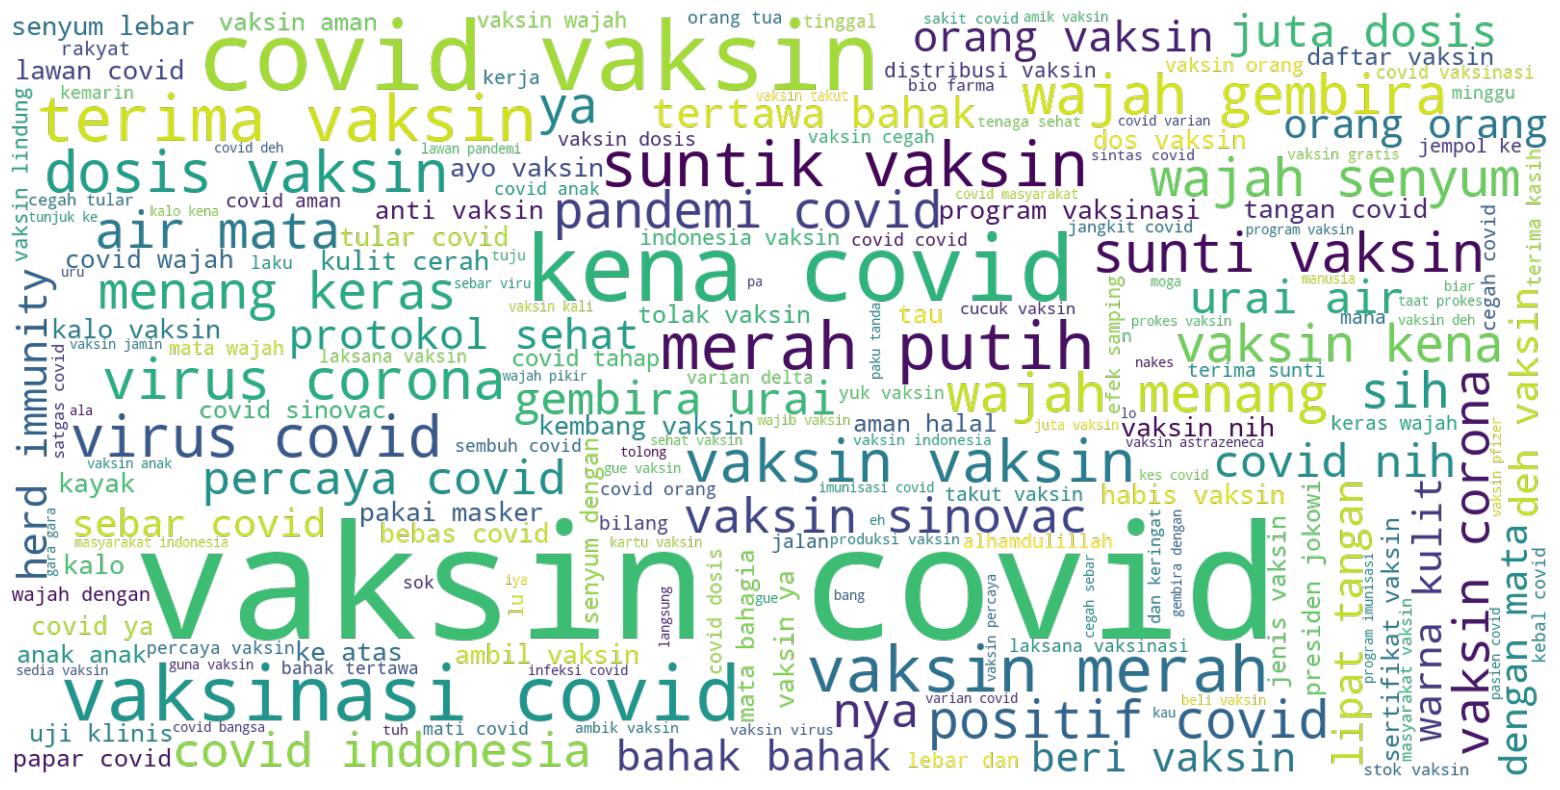

In [14]:
wordcloud = WordCloud(mode="RGBA", background_color=None, width=1600, 
                      height=800, random_state=2022, colormap='viridis')
wordcloud.generate(" ".join(data["cleaned"].tolist()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

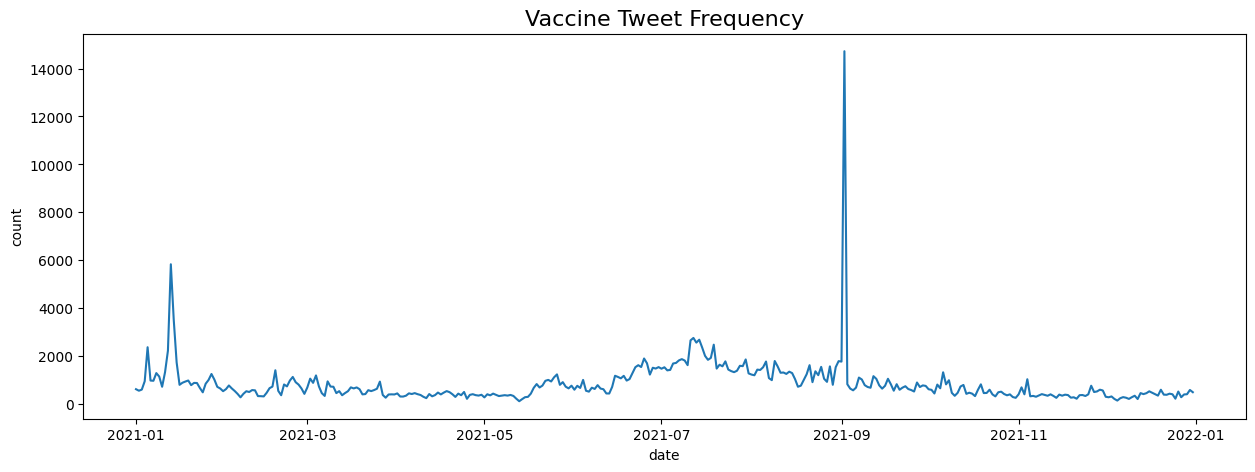

,date,count
0,2021-09-02,14722
1,2021-01-13,5835
2,2021-01-14,3520
3,2021-07-12,2762
4,2021-07-14,2688


In [9]:
tweet_freq = data["date"].dt.floor('d').value_counts().rename_axis('date').reset_index(name='count')
plt.figure(figsize=(15,5))
sns.lineplot(x = "date", y = "count", data = tweet_freq)
plt.title("Vaccine Tweet Frequency", fontsize=16)
plt.show()

tweet_freq.sort_values("count", ascending=False).head(5)

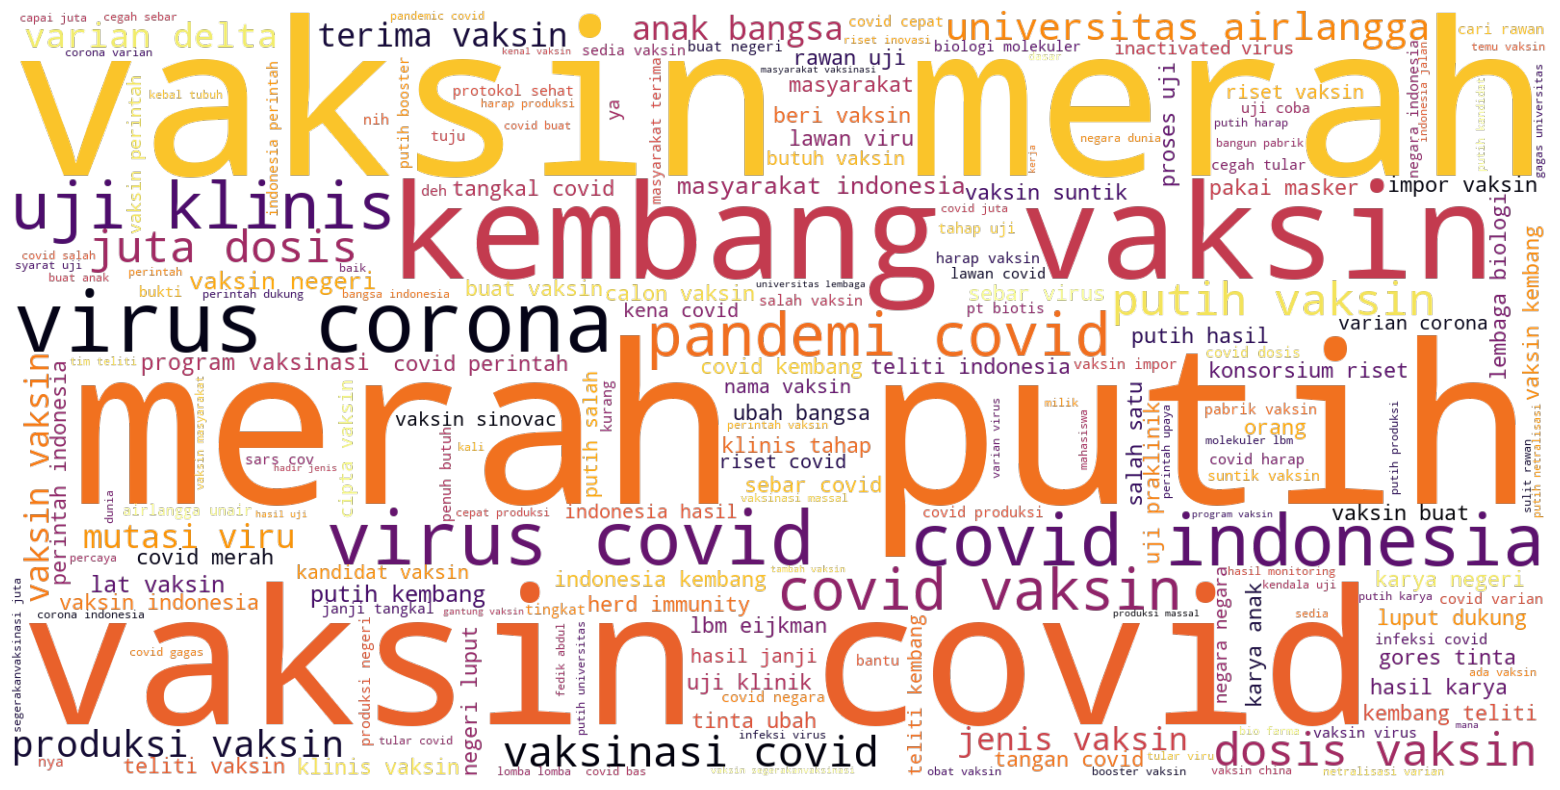

In [12]:
wordcloud = WordCloud(mode="RGBA", background_color=None, width=1600, 
                      height=800, random_state=2022, colormap='inferno')
wordcloud.generate(" ".join(data.query("'2021-09-01' < date < '2021-09-03'")["cleaned"].tolist()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()